# Title

## Introduction

This project focuses on assisting a computer science research group at The University of British Columbia that is looking into player behaviour in video games. Specifically, the research involves a Minecraft server which tracks player movements and actions and how they interact with the world. 

The research group need to target their recruitment efforts to make sure they have enough resources and have enough players to get an ample amount of data. They want to answer the research question: *Which types of players are most likely to contribute significant amounts of data?*

Answering this question is crucial to helping the research group optimize their recruitment. Therefore, by leveraging data science and machine learning techniques, this project aims to predict those player engagement patterns.

### Data
The data comes in two different datasets, the players data and the sessions data. Below are full data descriptions of both datasets. 

#### Players Data
The players dataset has 9 variables with 196 observations. It captures user information on for the minecraft server.

- experience: A ordinal categorical variable that describes the user's experience level with Minecraft. The categories range from - "Beginner", "Amateur", "Regular", "Pro", "Veteran".
- subscribe: A logical data variable, which is either TRUE, FALSE or NA. In this case, there is only TRUE or FALSE. This variable represents if the player is subscribed to the servers email updates.
- hashedEmail: A string variable of a hashed representation of the email the player used to sign up with.
- played_hours: A numeric variable detailing the total hours a user has spent on the server.
- name: A string variable representing the first name of the player.
- gender: a string variable representing the players gender.
- age: A numeric variable representing the players age.
- individualId: The variable is empty throughout the entire dataset but appears to be just a unique identifier for the player.
- organizationName: The variable is empty throughout the entire dataset but appears to be capture the organization which the player is associated with.

#### Sessions Data
The players dataset has 5 variables with 1535 observations. It captures video game session information for a player. It is linked to the player through the hashedEmail thus the two tables could be combined into one dataset to give more information.

Variables
- hashedEmail: A string variable representing the hashed email of a player.
- start_time: A string variable representing the start time of the session in the format of DD/MM/YYYY HH:MM
- end_time: A string variable representing the end time of the session in the format of DD/MM/YYYY HH:MM
- original_start_time: A numerical variable representing the start time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).
- original_end_time: A numerical variable representing the end time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).

In [3]:
library(tidyverse)
library(ggplot2)
library(repr)
library(readr)  
library(dplyr)
library(tidymodels)

ERROR: Error: package or namespace load failed for ‘tidymodels’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘recipes’


## Downloading Data

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players <- read.csv(players_url)
sessions <- read.csv(sessions_url)

In [3]:
head(players)

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<lgl>,<lgl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [3]:
head(sessions)

,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [4]:
players_selected <- players |>
select(-individualId, -organizationName, -name, -hashedEmail)
head(players_selected)

,experience,subscribe,played_hours,gender,age
,<chr>,<lgl>,<dbl>,<chr>,<int>
1,Pro,TRUE,30.3,Male,9
2,Veteran,TRUE,3.8,Male,17
3,Veteran,FALSE,0.0,Male,17
4,Amateur,TRUE,0.7,Female,21
5,Regular,TRUE,0.1,Male,21
6,Amateur,TRUE,0.0,Female,17


In [5]:
players_selected$subscribe <- as.numeric(players_selected$subscribe)

players_selected <- players_selected |>
    mutate(experience = as_factor(experience)) 

players_final <- players_selected |>
    drop_na()

head(players_final)

,experience,subscribe,played_hours,gender,age
,<fct>,<dbl>,<dbl>,<chr>,<int>
1,Pro,1,30.3,Male,9
2,Veteran,1,3.8,Male,17
3,Veteran,0,0.0,Male,17
4,Amateur,1,0.7,Female,21
5,Regular,1,0.1,Male,21
6,Amateur,1,0.0,Female,17


In [6]:
players_final_count <- players_selected |>
  group_by(experience) |>
  mutate(count = n()) |>
  ungroup()
head(players_final_count)

experience,subscribe,played_hours,gender,age,count
<fct>,<dbl>,<dbl>,<chr>,<int>,<int>
Pro,1,30.3,Male,9,14
Veteran,1,3.8,Male,17,48
Veteran,0,0.0,Male,17,48
Amateur,1,0.7,Female,21,63
Regular,1,0.1,Male,21,36
Amateur,1,0.0,Female,17,63


In [7]:
players_summary <- players_selected |>
  group_by(experience) |>
  summarise(
    avg_played_hours = mean(played_hours, na.rm = TRUE),
    avg_age = mean(age, na.rm = TRUE),
    subscribe_rate = mean(subscribe, na.rm = TRUE),
    gender_categories = paste(names(table(gender)), table(gender), sep = ":", collapse = ","),
    count = n(),
    .groups = "drop")
head(players_summary)


experience,avg_played_hours,avg_age,subscribe_rate,gender_categories,count
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Pro,2.6000000,22.21429,0.7142857,"Male:11,Non-binary:2,Other:1",14
Veteran,0.6479167,20.95833,0.6875000,"Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",48
Amateur,6.0174603,20.25397,0.7142857,"Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",63
Regular,18.2083333,22.77778,0.8055556,"Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",36
Beginner,1.2485714,21.65714,0.7714286,"Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1",35


In [8]:
players_gender <- players_summary
  experience = c("Pro", "Veteran", "Amateur", "Regular", "Beginner")
  gender_categories = c("Male:11,Non-binary:2,Other:1", 
                        "Agender:2,Female:5,Male:31,Non-binary:8,Prefer not to say:2",
                        "Female:14,Male:40,Non-binary:1,Prefer not to say:4,Two-Spirited:4",
                        "Female:4,Male:26,Non-binary:3,Prefer not to say:2,Two-Spirited:1",
                        "Female:14,Male:16,Non-binary:1,Prefer not to say:3,Two-Spirited:1")
  stringsAsFactors = FALSE

players_gender_final <- players_gender |>
  separate_rows(gender_categories, sep = ",") |>
  separate(gender_categories, into = c("gender", "count"), sep = ":") |>
  mutate(count = as.numeric(count))

players_one_hot <- players_gender_final %>%
  pivot_wider(names_from = gender, values_from = count, values_fill = list(count = 0))


players_final_one_hot <- players_one_hot |>
  group_by(experience) |>
  summarise(across(everything(), sum, na.rm = TRUE))
players_final_sum <- players_final_one_hot |>
  rowwise() |>
  mutate(total_gender_count = sum(c(Male, `Non-binary`, Other, Agender, Female, `Prefer not to say`, `Two-Spirited`), na.rm = TRUE)) |>
  ungroup()
players_final_sum



Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(everything(), sum, na.rm = TRUE)`.
ℹ In group 1: `experience = Pro`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


experience,avg_played_hours,avg_age,subscribe_rate,Male,Non-binary,Other,Agender,Female,Prefer not to say,Two-Spirited,total_gender_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,2.6000000,22.21429,0.7142857,11,2,1,0,0,0,0,14
Veteran,0.6479167,20.95833,0.6875000,31,8,0,2,5,2,0,48
Amateur,6.0174603,20.25397,0.7142857,40,1,0,0,14,4,4,63
Regular,18.2083333,22.77778,0.8055556,26,3,0,0,4,2,1,36
Beginner,1.2485714,21.65714,0.7714286,16,1,0,0,14,3,1,35


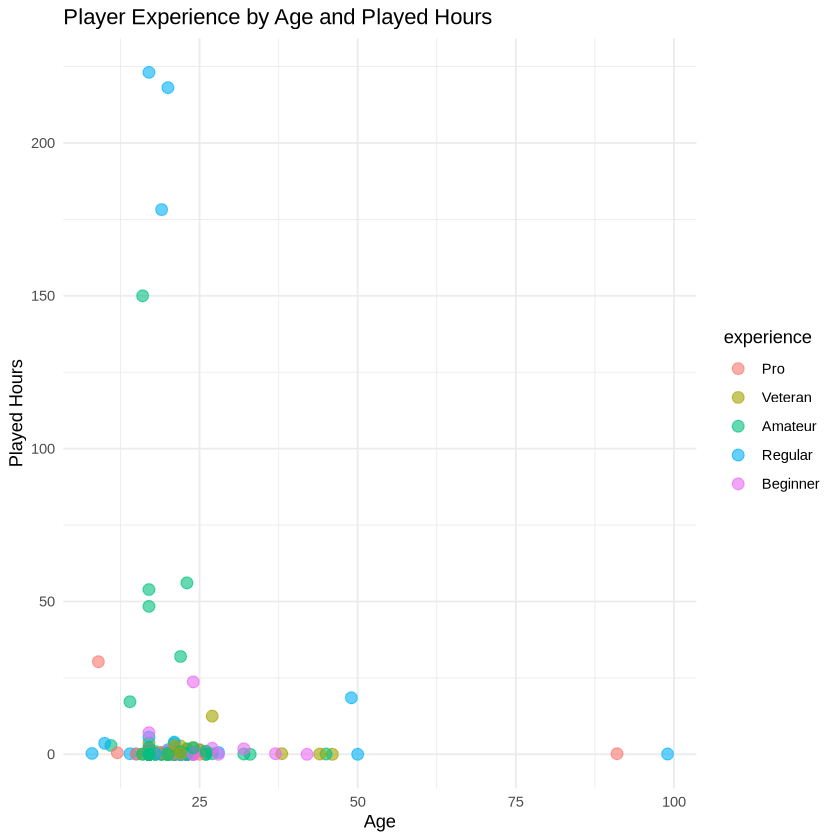

In [9]:

ggplot(players_final_count, aes(x = age, y = played_hours, color = experience)) +
  geom_point(size = 3, alpha = 0.6) +
  labs(title = "Player Experience by Age and Played Hours",
       x = "Age",
       y = "Played Hours") +
  theme_minimal() 


In [10]:
players_final_transformed <- players_final |>
  mutate(played_hours_log = log(played_hours + 1)) |>
pivot_wider(names_from = gender, values_from = gender, 
              values_fn = length, values_fill = list(gender = 0))
players_final_transformed


experience,subscribe,played_hours,age,played_hours_log,Male,Female,Non-binary,Prefer not to say,Agender,Two-Spirited,Other
<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Pro,1,30.3,9,3.44361810,1,0,0,0,0,0,0
Veteran,1,3.8,17,1.56861592,1,0,0,0,0,0,0
Veteran,0,0.0,17,0.00000000,1,0,1,0,0,0,0
Amateur,1,0.7,21,0.53062825,0,2,0,0,0,0,0
Regular,1,0.1,21,0.09531018,2,0,0,0,0,0,0
Amateur,1,0.0,17,0.00000000,4,4,0,1,0,1,0
Regular,1,0.0,19,0.00000000,0,1,0,0,0,0,0
Amateur,0,0.0,21,0.00000000,2,0,0,0,0,0,0
Amateur,1,0.1,17,0.09531018,3,0,0,0,0,0,0


In [11]:
players_final_transformed <- players_final |>
  mutate(played_hours_log = log(played_hours + 1),
         gender_numeric = case_when(
           gender == "Male" ~ 1,
           gender == "Female" ~ 2,
           gender == "Non-binary" ~ 3,
           TRUE ~ NA_real_))
players_final_transformed

experience,subscribe,played_hours,gender,age,played_hours_log,gender_numeric
<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
Pro,1,30.3,Male,9,3.44361810,1
Veteran,1,3.8,Male,17,1.56861592,1
Veteran,0,0.0,Male,17,0.00000000,1
Amateur,1,0.7,Female,21,0.53062825,2
Regular,1,0.1,Male,21,0.09531018,1
Amateur,1,0.0,Female,17,0.00000000,2
Regular,1,0.0,Female,19,0.00000000,2
Amateur,0,0.0,Male,21,0.00000000,1
Amateur,1,0.1,Male,17,0.09531018,1


In [13]:
players_split <- initial_split(players_final_transformed, prop = 0.75, strata = experience)
players_train <- training(players_split)
players_test <- testing(players_split)
glimpse(players_train)

ERROR: Error in initial_split(players_final_transformed, prop = 0.75, strata = experience): could not find function "initial_split"


In [14]:
players_proportions <- players_train |>
                      group_by(experience) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(players_train))

players_proportions

experience,n,percent
<fct>,<int>,<dbl>
Pro,11,7.534247
Veteran,36,24.657534
Amateur,46,31.506849
Regular,27,18.493151
Beginner,26,17.808219


In [15]:
players_recipe <- recipe(experience ~ age + played_hours_log + subscribe + gender, data = players_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors()) |>
  step_novel(all_nominal_predictors())


In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_mode("classification") |>
  set_engine("kknn") 
knn_fit <- workflow()|>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)
knn_fit


Attaching package: ‘kknn’


The following object is masked from ‘package:caret’:

    contr.dummy




══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_scale()
• step_center()
• step_dummy()
• step_novel()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6917808
Best kernel: rectangular
Best k: 5

In [17]:
validation_predicted <- predict(knn_fit, players_test) |>
  bind_cols(players_test) |>
  rename(predicted_experience = .pred_class)
validation_predicted

predicted_experience,experience,subscribe,played_hours,gender,age,played_hours_log,gender_numeric
<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
Amateur,Pro,1,30.3,Male,9,3.44361810,1
Regular,Veteran,1,3.8,Male,17,1.56861592,1
Amateur,Amateur,1,0.7,Female,21,0.53062825,2
Amateur,Amateur,1,0.0,Female,17,0.00000000,2
Amateur,Amateur,1,0.1,Male,17,0.09531018,1
Amateur,Veteran,1,1.6,Female,23,0.95551145,2
Amateur,Beginner,1,1.5,Female,25,0.91629073,2
Amateur,Amateur,1,48.4,Female,17,3.89995042,2
Pro,Amateur,1,0.5,Male,17,0.40546511,1


In [18]:
accuracy_result <- validation_predicted |>
  accuracy(truth = experience, estimate = predicted_experience) |>
  filter(.metric == "accuracy")
accuracy_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.36


In [19]:
precision_result <- validation_predicted |>
  precision(truth = experience, estimate = predicted_experience)
precision_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.3525


In [20]:
recall_result <- validation_predicted |>
  recall(truth = experience, estimate = predicted_experience)
recall_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.3120915


In [21]:
confusion_matrix_result <- validation_predicted |>
  conf_mat(truth = experience, estimate = predicted_experience)
confusion_matrix_result

          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        1       0       1       0        1
  Veteran    0       5       4       7        0
  Amateur    2       4      10       1        7
  Regular    0       2       2       1        0
  Beginner   0       1       0       0        1

In [2]:
knn_spec_tune <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = tune()  # Now tuning k instead of fixed k=5
) |>
  set_mode("classification") |>
  set_engine("kknn")

# 2. Create cross-validation folds
players_folds <- vfold_cv(players_train, v = 3, strata = experience)

# 3. Create grid of k values to try
k_grid <- tibble(neighbors = seq(1, 15, by = 2))

# 4. Tune the model
knn_tuning <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_tune) |>
  tune_grid(
    resamples = players_folds,
    grid = k_grid
  )

# 5. View best k value
show_best(knn_tuning, metric = "accuracy")

ERROR: Error in set_engine(set_mode(nearest_neighbor(weight_func = "rectangular", : could not find function "set_engine"


In [24]:
best_k <- show_best(knn_tuning, metric = "accuracy") %>%
  slice(1) %>%
  pull(neighbors)

# Retrain the model with the best k
knn_spec_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors = best_k
) %>%
  set_mode("classification") %>%
  set_engine("kknn")

# Retrain the workflow with the best k
final_knn_workflow <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(knn_spec_final)

# Fit the final model
final_knn_fit <- final_knn_workflow %>%
  fit(data = players_train)
final_knn_fit 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_scale()
• step_center()
• step_dummy()
• step_novel()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.7328767
Best kernel: rectangular
Best k: 7

In [26]:
test_predictions <- final_knn_fit %>%
  predict(new_data = players_test)

# Evaluate performance using the confusion matrix
confusion_matrix <- test_predictions %>%
  bind_cols(players_test) %>%
  conf_mat(truth = experience, estimate = .pred_class)

# Display the confusion matrix
confusion_matrix

# Calculate additional performance metrics like accuracy, precision, recall, etc.
metrics <- test_predictions %>%
  bind_cols(players_test) %>%
  metrics(truth = experience, estimate = .pred_class)

# View the metrics
metrics

          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        1       0       0       0        1
  Veteran    0       6       4       5        0
  Amateur    2       4      10       3        7
  Regular    0       2       2       1        0
  Beginner   0       0       1       0        1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.380000
kap,multiclass,0.143173


In [27]:
players_train_smote <- players_train %>%
  step_smote(experience, over_ratio = 1) %>%  # Adjust over-sampling ratio if needed
  prep(training = players_train) %>%
  bake(new_data = NULL)

# Step 2: Create new tuning grid with larger k values (1 to 30)
k_grid <- tibble(neighbors = seq(1, 30, by = 2))

# Step 3: Define the k-NN model with a different distance metric and tune `k`
knn_spec_tune <- nearest_neighbor(
  weight_func = "rectangular",  # You can change this to other options like 'gaussian'
  neighbors = tune(),           # Tuning `k`
  distance_metric = "euclidean" # Change distance metric from default if needed
) %>%
  set_mode("classification") %>%
  set_engine("kknn")

# Step 4: Create 5-fold cross-validation folds
players_folds <- vfold_cv(players_train_smote, v = 5, strata = experience)

# Step 5: Tune the model with a larger range of k values
knn_tuning <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(knn_spec_tune) %>%
  tune_grid(
    resamples = players_folds,
    grid = k_grid
  )

# Step 6: View the best `k` based on accuracy
show_best(knn_tuning, metric = "accuracy")

# Step 7: Evaluate performance on the test set
final_model <- finalize_model(knn_spec_tune, select_best(knn_tuning, metric = "accuracy"))
final_workflow <- workflow() %>%
  add_recipe(players_recipe) %>%
  add_model(final_model)

final_results <- final_workflow %>%
  fit(data = players_train_smote) %>%
  predict(new_data = players_test) %>%
  bind_cols(players_test) %>%
  metrics(truth = experience, estimate = .pred_class)

# Print final results (accuracy, precision, recall, etc.)
final_results

ERROR: Error in step_smote(., experience, over_ratio = 1): could not find function "step_smote"
